<a href="https://colab.research.google.com/github/Schimmenti/LCPGroup4/blob/master/LCP_Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAGIC Data Analysis
### Laboratory of Computational Physics @ Physics of Data, UniPD - 10/06/19
#### Braghetto Anna, Frazzetto Paolo, Martina Riccardo, Schimmenti Vincenzo Maria 
---


## 1. The Experiment and The Dataset
**MAGIC (Major Atmospheric Gamma Imaging Cherenkov Telescopes)** is a system of two Imaging Atmospheric Cherenkov telescopes situated at the Canary Islands, Spain. MAGIC detects particle showers released by high energy gamma rays using the Cherenkov radiation, i.e. the radiation emitted by charged particles leaking through the atmosphere that gets recorded in the detector, allowing reconstruction of the shower parameters by imaging techniques.

The [data](https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data) are Monte Carlo generated to simulate these detections. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, _the camera_. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (_shower images_), allowing to discriminate statistically those caused by primary gammas (_signal_) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (_background_).
Typically, the image of a shower after some pre-processing is an elongated cluster, as depicted below. Its long axis is oriented towards the camera center if the shower axis is parallel to the telescope's optical axis, i.e. if the telescope axis is directed towards a point source. A principal component analysis is performed in the camera plane, which results in a correlation axis and defines an ellipse. The characteristic parameters of this ellipse are among the image parameters that can be used for discrimination. The energy depositions are typically asymmetric along the major axis, and this asymmetry can also be used in discrimination. There are, in addition, further discriminating characteristics, like the extent of the cluster in the image plane, or the total sum of depositions.

![alt text](https://docs.google.com/uc?export=download&id=1gDT8Yrurov6vIg7knSglZ-uL5CaEmogO)

The dataset contains 19020 _samples_ described by 10 _features_ and one label:

1. fLength: continuous # major axis of ellipse [mm] 
2. fWidth: continuous # minor axis of ellipse [mm] 
3. fSize: continuous # 10-log of sum of content of all pixels [in #phot] 
4. fConc: continuous # ratio of sum of two highest pixels over fSize [ratio] 
5. fConc1: continuous # ratio of highest pixel over fSize [ratio] 
6. fAsym: continuous # distance from highest pixel to center, projected onto major axis [mm] 
7. fM3Long: continuous # 3rd root of third moment along major axis [mm] 
8. fM3Trans: continuous # 3rd root of third moment along minor axis [mm] 
9. fAlpha: continuous # angle of major axis with vector to origin [deg] 
10. fDist: continuous # distance from origin to center of ellipse [mm] 
11. class: $g, h$ # there are 12332 gammas (signal) and 6688 hadrons (background) 

For technical reasons, the number of *h* events is underestimated. In the real data, the *h* class represents the majority of the events. 
Moreover, we mapped the classes as $h \to 0$ and $g \to 1$ for practical purposes.


To evaluate the performance of a classifier we cannot simply use an accuracy measure (i.e. the fraction of correctly classified samples); since we don't treat on the same footing false positives and false negatives (i.e. we want to avoid classifyng a background as a signal) we measure the performance of the classifiers using a **ROC curve**. A ROC curve represents the false positive rate versus the true positive rate and each point of the curve represents a different way to put a threshold on the classifier, since all of them given a data point $x$ output $P[ y=1|x  ] \in [0,1]$ .

## 2. Data Analysis

### 2.1 A First Glance 
First of all, we downloaded the whole dataset and we went naively through it by means of a Seaborn pair plot, that showed us all the pair-wise correlations among the features and their KDE both for signal (green) and background (blue) events: 

In [1]:
#@title Library imports
#@markdown Here we load the necessary python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.mixture as mix

import sklearn
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import copy
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score,roc_curve,roc_auc_score
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split
#Precision = TP/TP+FP
#Recall = TP/TP+FN
#F1 Score = 2*(Recall * Precision) / (Recall + Precision)

np.set_printoptions(precision=2,suppress=True)

from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
rcParams['font.size'] = 18
rcParams['legend.fontsize'] = 'large'
rcParams['figure.titlesize'] = 'medium'

sns.set()
sns.set_style("ticks")

In [2]:
#@title Data Preparation
#@markdown Here we load the dataset .
ID=1204565
np.random.seed(ID)
file_name = 'magic04.data'
#magic = pd.read_csv(file_name)
magic = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data')
magic.columns = ["fLength","fWidth","fSize","fConc","fConc1","fAsym","fM3Long","fM3Trans","fAlpha","fDist","class"]
cdf = copy.deepcopy(magic.dropna(0, how='any'))
cdf.loc[cdf['class'] == 'g','class'] = 1 #gamma - signal
cdf.loc[cdf['class'] == 'h','class'] = 0 #hadron - background
X = cdf.drop('class',axis=1)
Y = cdf['class']

cut_mask = X['fAlpha'] <= 21.8
X_cut = X[cut_mask]
Y_cut = Y[cut_mask]


X.describe()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
count,19019.000000,19019.000000,19019.000000,19019.000000,19019.000000,19019.000000,19019.000000,19019.000000,19019.000000,19019.000000
mean,53.251440,22.181291,2.825026,0.380326,0.214658,-4.333429,10.544942,0.250170,27.645052,193.823912
std,42.365598,18.346484,0.472609,0.182818,0.110514,59.207163,51.001391,20.827896,26.104151,74.729344
min,4.283500,0.000000,1.941300,0.013100,0.000300,-457.916100,-331.780000,-205.894700,0.000000,1.282600
25%,24.336000,11.863700,2.477100,0.235800,0.128450,-20.588300,-12.845050,-10.849750,5.546950,142.499000
50%,37.149000,17.140600,2.739600,0.354100,0.196500,4.011900,15.309400,0.689800,17.677000,191.856900
75%,70.126850,24.739950,3.101600,0.503700,0.285250,24.060350,35.844100,10.947050,45.884100,240.564550
max,334.177000,256.382000,5.323300,0.893000,0.675200,575.240700,238.321000,179.851000,90.000000,495.561000


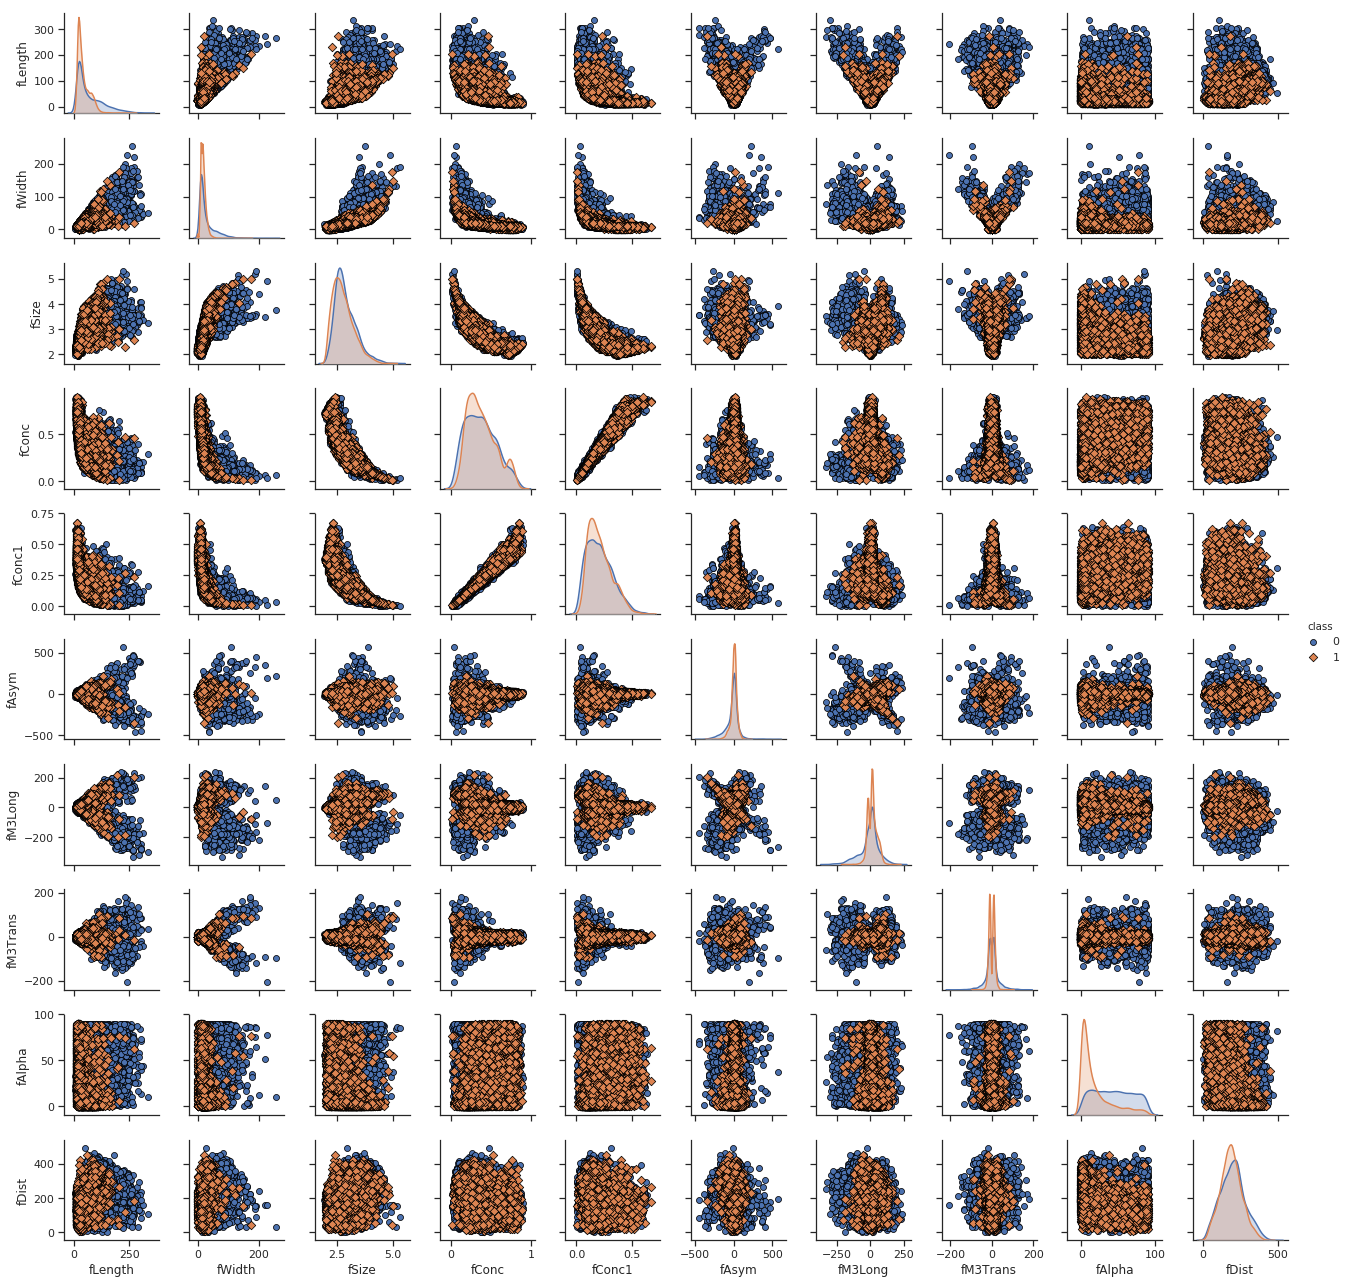

In [3]:
#@title Pairplot
#@markdown Use this cell to make a pairplot of all the features
pplot = sns.pairplot(cdf, vars=list(cdf.columns[:-1]), hue="class", markers=["o", "D"], plot_kws=dict(edgecolor="black"),diag_kind="kde",diag_kws=dict(shade=True), height = 1.8)

Notice that not all the features are correlated or display some differences between signal and event. However, for some of them we can say that backgound events (blue) manifest a more sparse or uniform distribution, such as for _fAlpha, fLenght, fWidth_ or _fSize_. Furthermore, for these feature their KDEs are more peaked for signal events (see next plot) and, as we will see later in the analysis, they are the most relevant features for the discrimination.

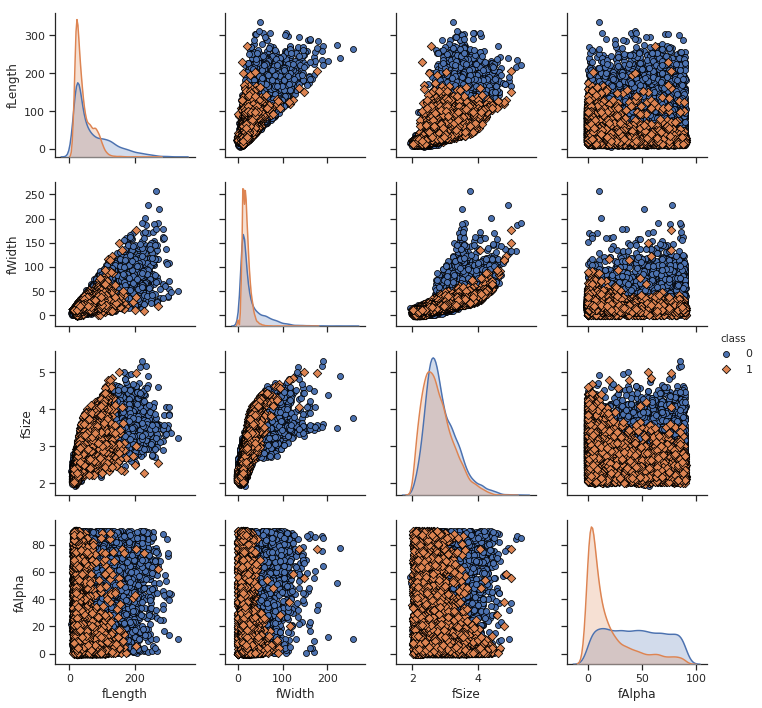

In [4]:
#@markdown Run to show the Pairplot for some most relevant features
pplot_detail = sns.pairplot(cdf, vars=['fLength', 'fWidth', 'fSize', 'fAlpha'], hue="class", markers=["o", "D"], plot_kws=dict(edgecolor="black"), diag_kind="kde",diag_kws=dict(shade=True))

We notice from the distribution of  _fAlpha_ that  there is a remarkable difference between gammas and hadrons. This fact is physically reasonable since _fAlpha_ is the angle of the major ellipse axis with the source and we expect it to be uniformly distributed for background and peaked for signal.

### 2.2 Preprocessing
The dataset is divide into 70% of train data and 30% of test. Before going into the actual data analysis we performed a feature scaling on our data, i.e. we centered the points around their sample mean and scaled by their sample standard deviation. This is done since it is empirically proved that some machine learning algorithms perform better after this kind of scaling.

In [0]:
#@title Preprocessing
#@markdown Run to preprocess data as described above.


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7,random_state=ID)
ss = StandardScaler();
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

### 2.3 Feature Study

We start by computing the correlation matrix between the features. We observe a storng correlation among the first three features, i.e. fWidth, fLength and fSize. An important thing to notice is that the correlation between fAlpha and the others is not that strong, so we can consider it as an independent variable (the same result will be observed in the PCA where the 5-th principal component is mostly made up of fAlpha).

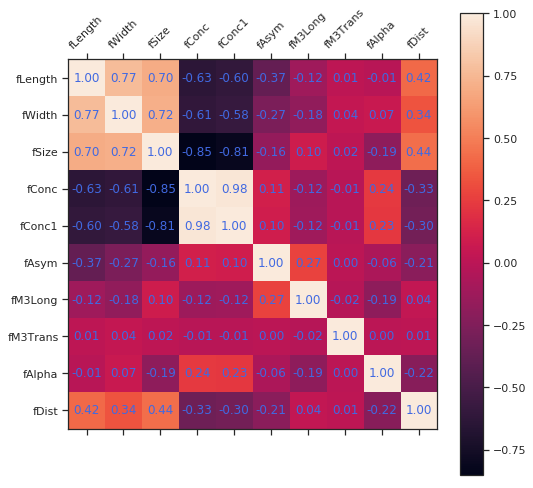

In [6]:
#@markdown Plot Correlation Matrix
corrMatrix = np.corrcoef(X, rowvar=False)
plt.matshow(corrMatrix)
plt.xticks(np.arange(0,10),list(X.columns), rotation=45)
plt.yticks(np.arange(0,10),list(X.columns))
plt.colorbar()
for (i, j), z in np.ndenumerate(corrMatrix):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', color='royalblue')
plt.show()

Then, as the assignement suggests, starting from the _mean-scaled-width_ and the _mean-scale-length_, i.e. the rescaled _fWidth_ and _fLength_ distributions,  we compare them for signal and background events in the cases of little or a lot of light (_fSize_).

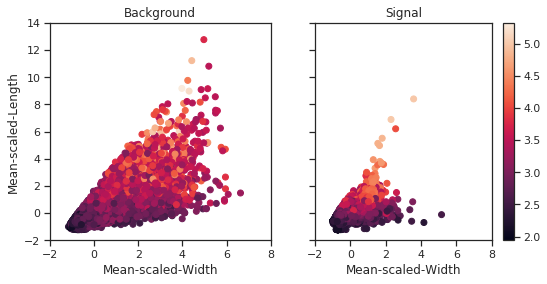

In [7]:
#@markdown Show _fWidth_ vs. _fLength_ colored by _fSize_. Notice thta smaller ellipses manifest less brightness. 

X_lw = np.copy(X.values[:,[0,1] ])
fSize = np.copy(X.values[:,2])

ss = StandardScaler()
X_lw = ss.fit_transform(X_lw)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey=True)

im1 = ax1.scatter(x=X_lw[Y==0,0], y=X_lw[Y==0,1], c=fSize[Y==0], vmin=np.min(fSize), vmax=np.max(fSize), label='Background' )
im2 = ax2.scatter(x=X_lw[Y==1,0], y=X_lw[Y==1,1], c=fSize[Y==1], vmin=np.min(fSize), vmax=np.max(fSize), label='Signal' )
ax1.set_xlim(-2,8)
ax1.set_ylim(-2,14)
ax2.set_xlim(-2,8)
ax2.set_ylim(-2,14)
ax1.set_xlabel('Mean-scaled-Width')
ax1.set_ylabel('Mean-scaled-Length')
ax2.set_xlabel('Mean-scaled-Width')
#ax2.set_ylabel('Mean-scaled-Length')
ax1.set_title('Background')
ax2.set_title('Signal')
#fig.colorbar(im1,ax=ax1)
fig.subplots_adjust(right=0.8)
fig.colorbar(im2,ax=ax2)
plt.show()

Above we used physical reasoning to gain some insights on the features. Here we would like to follow a more algorithmic approach to determine which features are the most relevant. One quick and standard method is to perform a __PCA__.

Each principal component retains a fraction of the total variance of the data and within each component we can determine which feature is contributing the most.

In [8]:
def normalizeByRow(Z):
  """Function used to show percentage composition of PCA components"""
  norm = np.sum(np.abs(Z), axis=1)
  return np.abs(Z)/norm[:,None] 

# PCA
components_to_keep = 10 #choose the new dimensionality
pca = PCA(svd_solver='full', n_components=components_to_keep)
X_pca = pca.fit_transform(X)
print("Explained variance ratios", pca.explained_variance_ratio_)
#print("Keeping variance ratio of",np.sum(pca.explained_variance_ratio_[0:components_tokeep]), "using", components_tokeep, "components")
print('Predicted feature importance per component:')
print('Each row is representing a different principal component')
print('Each column  determines the percentual influence of the feature inside that component')
print('\n')
X_fimp = normalizeByRow(pca.components_)
print(X_fimp)

usePCAedData = False
if(usePCAedData):
  X_train, X_test, Y_train,Y_test = train_test_split(X_pca, Y, train_size=0.7,random_state=ID)
  ss = StandardScaler();
  ss.fit(X_test)
  X_train = ss.transform(X_train)
  X_test = ss.transform(X_test)

Explained variance ratios [0.44 0.26 0.13 0.09 0.04 0.03 0.01 0.   0.   0.  ]
Predicted feature importance per component:
Each row is representing a different principal component
Each column  determines the percentual influence of the feature inside that component


[[0.18 0.06 0.   0.   0.   0.21 0.04 0.   0.03 0.47]
 [0.07 0.03 0.   0.   0.   0.35 0.29 0.   0.06 0.21]
 [0.04 0.01 0.   0.   0.   0.32 0.48 0.01 0.03 0.12]
 [0.46 0.17 0.   0.   0.   0.15 0.04 0.01 0.05 0.12]
 [0.07 0.01 0.   0.   0.   0.   0.08 0.01 0.74 0.08]
 [0.02 0.02 0.   0.   0.   0.01 0.01 0.93 0.01 0.  ]
 [0.24 0.66 0.01 0.   0.   0.02 0.02 0.02 0.04 0.  ]
 [0.   0.01 0.63 0.22 0.13 0.   0.   0.   0.   0.  ]
 [0.   0.   0.22 0.46 0.31 0.   0.   0.   0.   0.  ]
 [0.   0.   0.02 0.39 0.59 0.   0.   0.   0.   0.  ]]


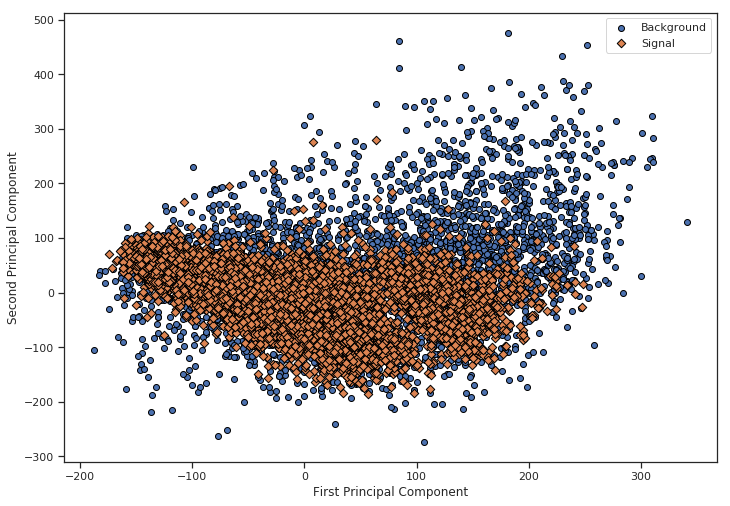

In [9]:
# Plot of first 2 components
plt.figure()
plt.scatter(X_pca[Y==0,0],X_pca[Y==0,1], label='Background',edgecolors='black',marker="o")
plt.scatter(X_pca[Y==1,0],X_pca[Y==1,1], label='Signal', edgecolors='black', marker="D")
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.show()

The ready-to-use implementation of PCA from _scikit-learn_ tell us that 99% of the variance can be expressed using only 6 components, so not all features are that relevant. This can be also inferred by physical reasoning, as above suggested. In fact, these data are not raw measurements but they have already been processed to obtain some physically significant quantities, therefore it is reasonable that some of them will be more suited to classify hadrons and gammas.


Another way to study feature importance is via unsupervised __Random Forest (RF)__ classifier that not only tries to learn a way to map data to labels but tells how much a feature in the data is important in this mapping.

In [10]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_jobs=-1, random_state=ID)
param_grid = {'n_estimators' : np.arange(60, 80,5)} # Cross Validation
gsCV = GridSearchCV(rfc, param_grid=param_grid, n_jobs=-1, cv=5, return_train_score=True, verbose=1)
gsCV.fit(X, Y)
bestRfc = gsCV.best_estimator_
print("Predicted feaures importances", bestRfc.feature_importances_, "using", gsCV.best_params_['n_estimators'], "estimators")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   51.3s finished


Predicted feaures importances [0.16 0.13 0.12 0.06 0.05 0.05 0.08 0.05 0.24 0.07] using 70 estimators


We observe that only 4 of the features matter more w.r.t. the uniform importance, i.e. $10 \%$. These are again  _fAlpha, fLenght, fWidth_ and _fSize_. This result differs by the one from PCA: while the PCA looks for the variance of the data the importances computed by the RF are more linked to complexity (the RF used in this fashion is a supervised feature selector).

## 3. Classification

### 3.1 Approach description
For all models we used for classification we used cross validation to fix the important hyperparameters of the model and we picked the best one by looking at training test and validation scores. Each classifier, as we said, outputs a probability of labeling the data as signal and we used Scikit-learn internal methods to build the ROC curve and compute the **area under curve (AUC)** that will be used for comparing the models; a perfect classifier has an AUC of $1$ while a uninformative (i.e. random) has AUC of $0.5$. We also employ the **Quality factor** method to rank them: the quality factor of a classifier is defined as:
$$Q=\frac{\text{TPR}}{\sqrt{\text{FPR}} } $$
where $TPR$ is the true positive rate and $FPR$ is the false positive rate. To compare the models, we look at $Q$ for $TPR=0.5$.

In [0]:
def classification_rates(p,cY, tY):
  """
  Function that outputs the TPR, the FPR, the accuracy, the Q factor and its value at TPR=0.5.
  p stands for the probability threshold, whereas cY and tY are the classified and true labels respectively.
  """
  tp = np.heaviside(cY[tY==1][:, np.newaxis] -p,0)
  tpLen = tp.shape[0]
  tp = np.sum(tp, axis=0)
  
  
  tn = np.heaviside(-cY[tY==0][:, np.newaxis] + p,0)
  tnLen = tn.shape[0]
  tn = np.sum(tn, axis=0)
  
  acc = (tp+tn)/(tpLen+tnLen)
  
  tp = tp/tpLen
  tn=tn/tnLen
  
  tpHalfIndex = np.argmin(np.abs(tp-0.5))
  
  fp = np.heaviside(cY[tY==0][:, np.newaxis]-p, 0)
  fp = np.sum(fp, axis=0)/fp.shape[0]
  Q = tp/np.sqrt(fp+1E-8)
  
  return tp, fp, acc, Q, Q[tpHalfIndex]

### 3.2 Logistic Regression

In [0]:
lReg=LogisticRegression(random_state=ID, max_iter=300,n_jobs=-1, solver='lbfgs')
params = {'C':np.arange(0.5,10,0.5)}
gsCV = GridSearchCV(lReg, cv=5, n_jobs=-1, param_grid=params, return_train_score=True)
gsCV.fit(X_train, Y_train)
bestC=gsCV.best_params_['C']
bestLReg = gsCV.best_estimator_

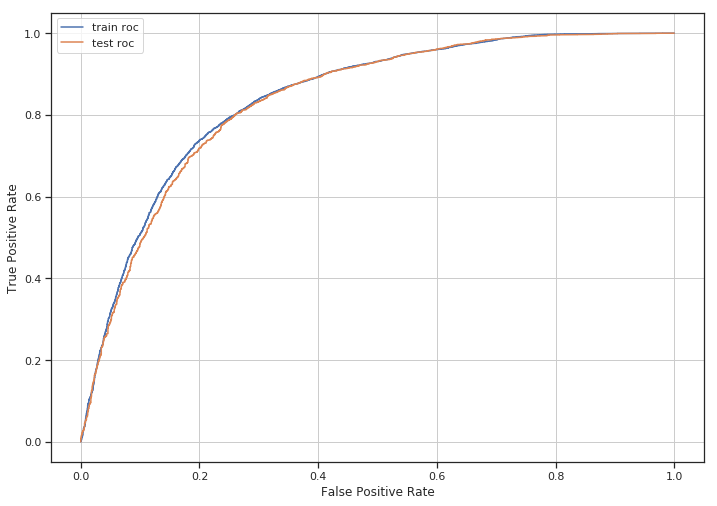

AUC train 0.8415995773046225
AUC test 0.8361971594317084


In [15]:
Y_train_predict = bestLReg.predict_proba(X_train)
Y_test_predict = bestLReg.predict_proba(X_test)
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, Y_train_predict[:,1], pos_label =1)
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, Y_test_predict[:,1], pos_label =1)
plt.figure()
plt.plot(train_fpr, train_tpr, label='train roc')
plt.plot(test_fpr, test_tpr, label='test roc')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()
print('AUC train', roc_auc_score(Y_train, Y_train_predict[:,1]))
print('AUC test', roc_auc_score(Y_test, Y_test_predict[:,1]))

Maximum Q: 1.617405668262031  with accuracy:  0.7046968103750438  at threshold:  0.7959183673469387  TPR:  0.6355799373040752  FPR:  0.154419595314164
Maximum Accuracy: 0.7972309849281458  with Q:  1.4266979209024955  at threshold:  0.5102040816326531  TPR:  0.8876698014629049  FPR:  0.3871139510117146
Q0.5:  1.5430083139094266


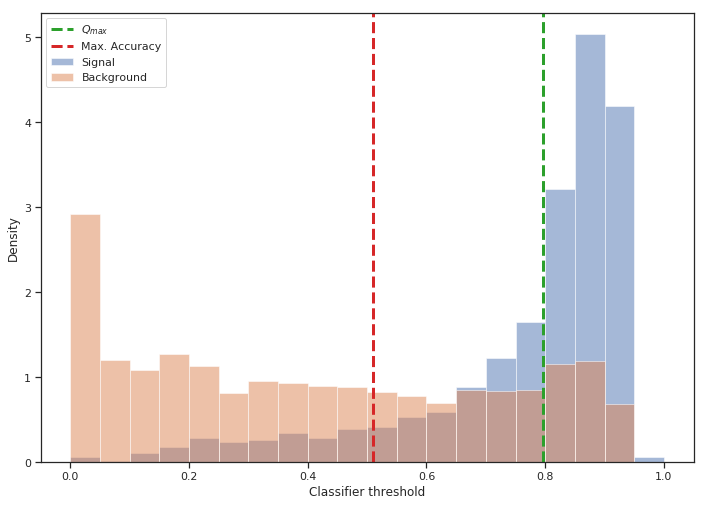

In [16]:
signal = Y_test_predict[Y_test==1]
background = Y_test_predict[Y_test==0]


thr = np.linspace(0,1,50)
tp, fp, acc, Q, Qest = classification_rates(thr,Y_test_predict[:,1] , Y_test)

QMaxIndex = np.argmax(Q)
accMaxIndex = np.argmax(acc)

print('Maximum Q:', Q[QMaxIndex], ' with accuracy: ', acc[QMaxIndex], ' at threshold: ', thr[QMaxIndex], ' TPR: ', tp[QMaxIndex], ' FPR: ', fp[QMaxIndex])
print('Maximum Accuracy:', acc[accMaxIndex], ' with Q: ', Q[accMaxIndex], ' at threshold: ', thr[accMaxIndex],' TPR: ', tp[accMaxIndex], ' FPR: ', fp[accMaxIndex])



print('Q0.5: ', Qest)

plt.figure()
plt.hist(signal[:,1], alpha=0.5, range=(0,1), bins=20, density=True, label='Signal')
plt.hist(background[:,1], alpha=0.5, range=(0,1), bins=20,density=True, label='Background' );
plt.axvline(thr[QMaxIndex], label="$Q_{max}$", c='#2ca02c',ls='--', lw=3)
plt.axvline(thr[accMaxIndex], label="Max. Accuracy", c='#d62728', ls='--', lw=3)

plt.xlabel('Classifier threshold')
plt.ylabel('Density')
plt.legend()
plt.show()

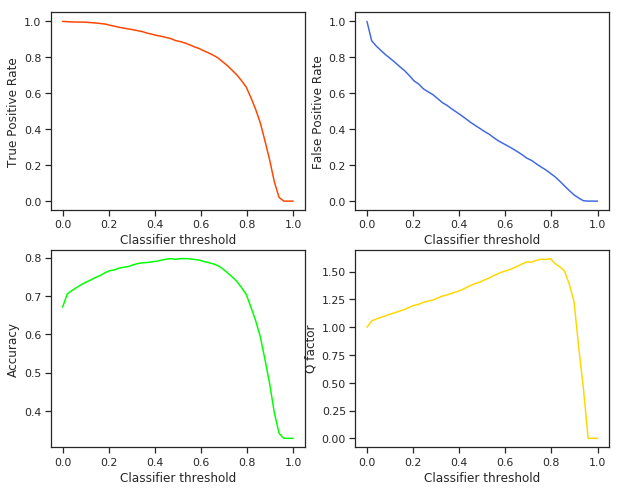

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
axs[0,0].plot(thr, tp, c='orangered')
axs[0,0].set_xlabel('Classifier threshold')
axs[0,0].set_ylabel('True Positive Rate')
axs[0,1].plot(thr, fp, c='royalblue')
axs[0,1].set_xlabel('Classifier threshold')
axs[0,1].set_ylabel('False Positive Rate')
axs[1,0].plot(thr, acc, c='lime')
axs[1,0].set_xlabel('Classifier threshold')
axs[1,0].set_ylabel('Accuracy')
axs[1,1].plot(thr, Q, c='gold')
axs[1,1].set_xlabel('Classifier threshold')
axs[1,1].set_ylabel('Q factor')
plt.show()

The ROC curve is relatively good; the train and test results are pretty similar (no overfitting): this is due the low complexity of the model (bias-variance tradeoff).

### 3.3 Random Forest Regressor

In [18]:
rfg =  RandomForestRegressor(n_jobs=-1, random_state=ID)
param_grid = {'n_estimators' : np.arange(80, 100, 5), 'min_samples_leaf' : [2,0.1]} 
gsCV = GridSearchCV(rfg, param_grid=param_grid, n_jobs=-1, cv=5, return_train_score=True, verbose=1)
gsCV.fit(X_train, Y_train)
bestRfg = gsCV.best_estimator_
bestNEst = gsCV.best_params_['n_estimators']
print(gsCV.best_params_)
#pd.DataFrame(gsCV.cv_results_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.0min finished


{'min_samples_leaf': 2, 'n_estimators': 85}


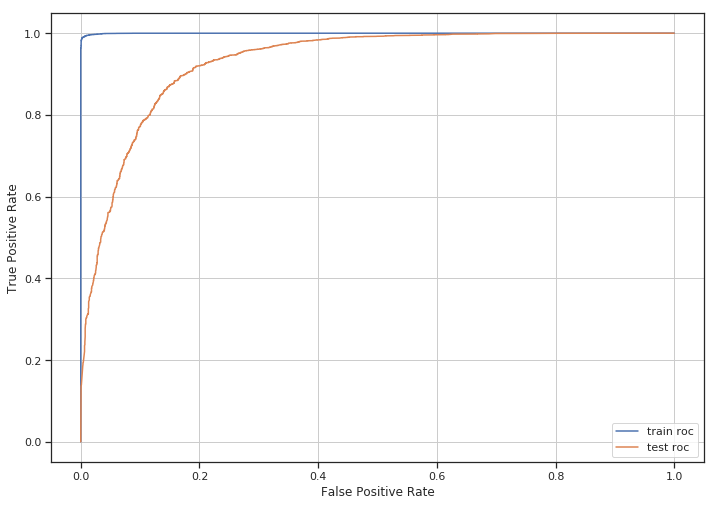

AUC train 0.9997733953749477
AUC test 0.9303357052957693


In [19]:
Y_train_predict = bestRfg.predict(X_train)
Y_test_predict = bestRfg.predict(X_test)
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, Y_train_predict, pos_label =1)
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, Y_test_predict, pos_label =1)
plt.figure()
plt.plot(train_fpr, train_tpr, label='train roc')
plt.plot(test_fpr, test_tpr, label='test roc')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()
print('AUC train', roc_auc_score(Y_train, Y_train_predict))
print('AUC test', roc_auc_score(Y_test, Y_test_predict))

Maximum Q: 3.070984312779353  with accuracy:  0.5045566070802664  at threshold:  0.9795918367346939  TPR:  0.26515151515151514  FPR:  0.007454739084132056
Maximum Accuracy: 0.8817034700315457  with Q:  2.077868070281924  at threshold:  0.5714285714285714  TPR:  0.9198014629049112  FPR:  0.1959531416400426
Q0.5:  2.6985263148294307


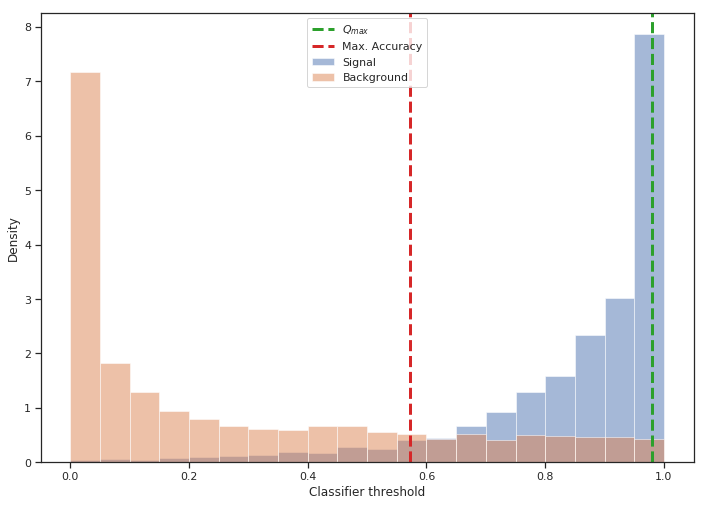

In [20]:
signal = Y_test_predict[Y_test==1]
background = Y_test_predict[Y_test==0]

thr = np.linspace(0,1,50)
tp, fp, acc, Q, Qest = classification_rates(thr,Y_test_predict , Y_test)



QMaxIndex = np.argmax(Q)
accMaxIndex = np.argmax(acc)

print('Maximum Q:', Q[QMaxIndex], ' with accuracy: ', acc[QMaxIndex], ' at threshold: ', thr[QMaxIndex], ' TPR: ', tp[QMaxIndex], ' FPR: ', fp[QMaxIndex])
print('Maximum Accuracy:', acc[accMaxIndex], ' with Q: ', Q[accMaxIndex], ' at threshold: ', thr[accMaxIndex],' TPR: ', tp[accMaxIndex], ' FPR: ', fp[accMaxIndex])



print('Q0.5: ', Qest)

prob_s, n_s, _ = plt.hist(signal, alpha=0.5, range=(0,1), bins=20, density=True, label='Signal')
prob_b, n_b, _ = plt.hist(background, alpha=0.5, range=(0,1), bins=20,density=True, label='Background' );
plt.axvline(thr[QMaxIndex], label="$Q_{max}$", c='#2ca02c',ls='--', lw=3)
plt.axvline(thr[accMaxIndex], label="Max. Accuracy", c='#d62728', ls='--', lw=3)
plt.legend(loc=9)
plt.xlabel('Classifier threshold')
plt.ylabel('Density')
plt.show()

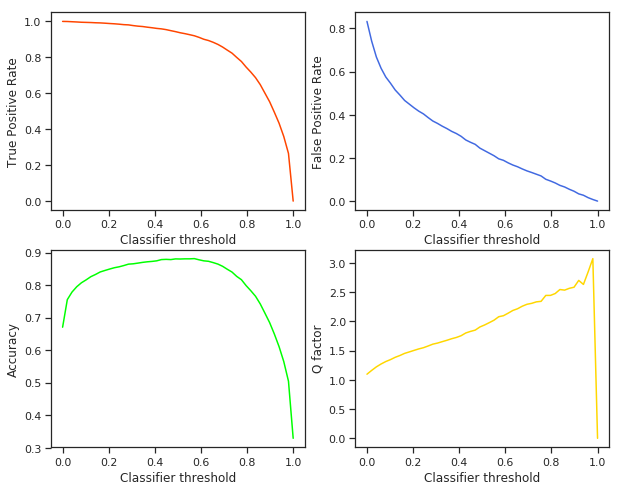

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
axs[0,0].plot(thr, tp, c='orangered')
axs[0,0].set_xlabel('Classifier threshold')
axs[0,0].set_ylabel('True Positive Rate')
axs[0,1].plot(thr, fp, c='royalblue')
axs[0,1].set_xlabel('Classifier threshold')
axs[0,1].set_ylabel('False Positive Rate')
axs[1,0].plot(thr, acc, c='lime')
axs[1,0].set_xlabel('Classifier threshold')
axs[1,0].set_ylabel('Accuracy')
axs[1,1].plot(thr, Q, c='gold')
axs[1,1].set_xlabel('Classifier threshold')
axs[1,1].set_ylabel('Q factor')
plt.show()

### 3.4 XGBoost

In [22]:
cv_params = {'max_depth': [3,4,5,6], 'min_child_weight': [1,2,3,4,5], 'learning_rate':[0.1,0.3,0.5]}
ind_params = {'n_estimators': 100, 'seed':ID, 'colsample_bytree': 1, 
             'objective': 'binary:logistic'}
opt_XGBclassifier = GridSearchCV(xgb.XGBClassifier(**ind_params),cv_params, scoring = 'accuracy', cv = 5, n_jobs = -1, verbose=3)
opt_XGBclassifier.fit(X_train, Y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=1204565,
                                     silent=None, subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.5],
                         'max_depth': [3, 4, 5, 6],
                         'min_child_weight': [1, 2, 3, 

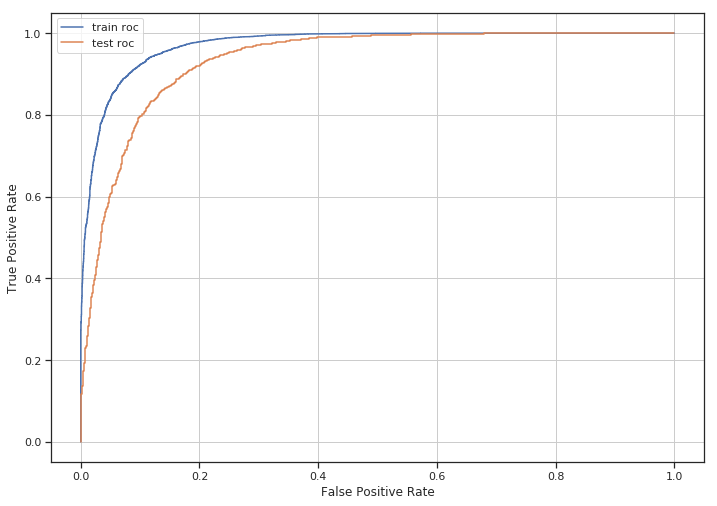

AUC train 0.9719564918141891
AUC test 0.9336493167880189


In [23]:
bestXGB=opt_XGBclassifier.best_estimator_


Y_train_predict = bestXGB.predict_proba(X_train)
Y_test_predict = bestXGB.predict_proba(X_test)
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, Y_train_predict[:,1], pos_label =1)
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, Y_test_predict[:,1], pos_label =1)
plt.figure()
plt.plot(train_fpr, train_tpr, label='train roc')
plt.plot(test_fpr, test_tpr, label='test roc')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()
print('AUC train', roc_auc_score(Y_train, Y_train_predict[:,1]))
print('AUC test', roc_auc_score(Y_test, Y_test_predict[:,1]))

Maximum Q: 2.7965888180738108  with accuracy:  0.6766561514195584  at threshold:  0.9183673469387754  TPR:  0.5360501567398119  FPR:  0.036741214057507986
Maximum Accuracy: 0.8859095688748686  with Q:  1.9339928460378562  at threshold:  0.4897959183673469  TPR:  0.9477533960292581  FPR:  0.24014909478168264
Q0.5:  2.7965888180738108


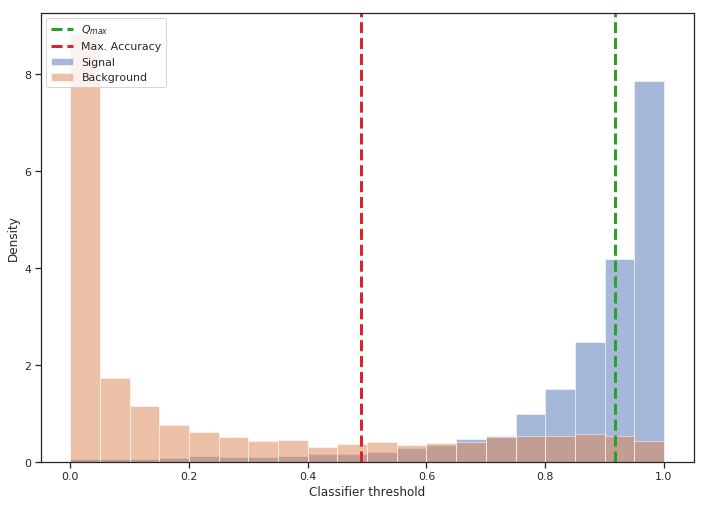

In [24]:
signal = Y_test_predict[Y_test==1]
background = Y_test_predict[Y_test==0]

thr = np.linspace(0,1,50)
tp, fp, acc, Q, Qest = classification_rates(thr,Y_test_predict[:,1] , Y_test)



QMaxIndex = np.argmax(Q)
accMaxIndex = np.argmax(acc)

print('Maximum Q:', Q[QMaxIndex], ' with accuracy: ', acc[QMaxIndex], ' at threshold: ', thr[QMaxIndex], ' TPR: ', tp[QMaxIndex], ' FPR: ', fp[QMaxIndex])
print('Maximum Accuracy:', acc[accMaxIndex], ' with Q: ', Q[accMaxIndex], ' at threshold: ', thr[accMaxIndex],' TPR: ', tp[accMaxIndex], ' FPR: ', fp[accMaxIndex])



print('Q0.5: ', Qest)


plt.hist(signal[:,1], alpha=0.5, range=(0,1), bins=20, density=True, label='Signal')
plt.hist(background[:,1], alpha=0.5, range=(0,1), bins=20,density=True, label='Background' );
plt.axvline(thr[QMaxIndex], label="$Q_{max}$", c='#2ca02c',ls='--', lw=3)
plt.axvline(thr[accMaxIndex], label="Max. Accuracy", c='#d62728', ls='--', lw=3)
plt.xlabel('Classifier threshold')
plt.ylabel('Density')
plt.legend()
plt.show()

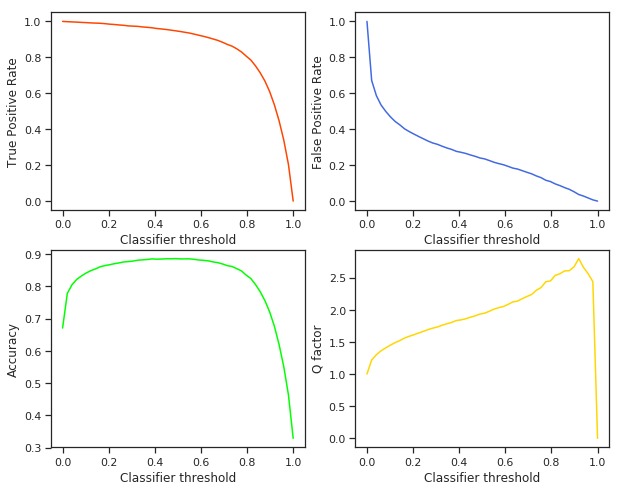

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
axs[0,0].plot(thr, tp, c='orangered')
axs[0,0].set_xlabel('Classifier threshold')
axs[0,0].set_ylabel('True Positive Rate')
axs[0,1].plot(thr, fp, c='royalblue')
axs[0,1].set_xlabel('Classifier threshold')
axs[0,1].set_ylabel('False Positive Rate')
axs[1,0].plot(thr, acc, c='lime')
axs[1,0].set_xlabel('Classifier threshold')
axs[1,0].set_ylabel('Accuracy')
axs[1,1].plot(thr, Q, c='gold')
axs[1,1].set_xlabel('Classifier threshold')
axs[1,1].set_ylabel('Q factor')
plt.show()

### 3.5 Neural Network Regressor

In [26]:
hidden_layer_sizes = [(50,), (100,), (50,50), (100,100), (50,50,50), (100,100,100)]
param_grid = {'hidden_layer_sizes':hidden_layer_sizes}
mlp = MLPRegressor(activation='relu', solver='adam', random_state=ID, max_iter=300)
gsCV = GridSearchCV(mlp, n_jobs=-1, param_grid=param_grid, cv=5, return_train_score=True, verbose=5)
gsCV.fit(X_train, Y_train)
bestSz = gsCV.best_params_['hidden_layer_sizes']
bestNN = gsCV.best_estimator_
print(bestNN)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.8min finished


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(50, 50), learning_rate='constant',
             learning_rate_init=0.001, max_iter=300, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=1204565, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)


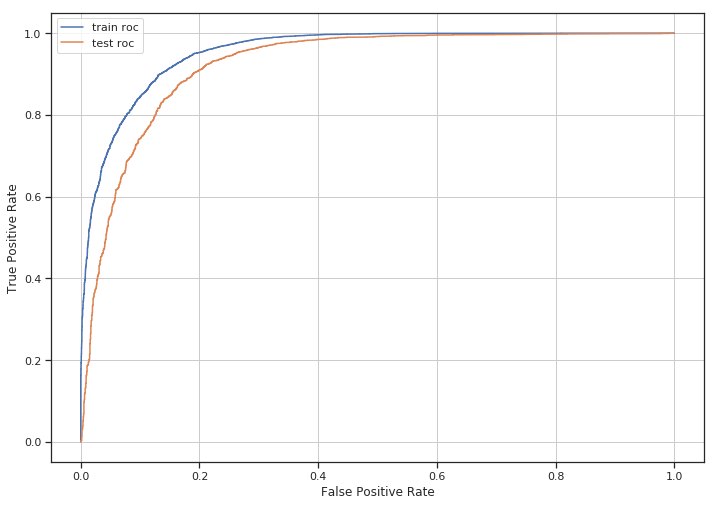

AUC train 0.9547580491953066
AUC test 0.9229779896575093


In [27]:
Y_train_predict = bestNN.predict(X_train)
Y_test_predict = bestNN.predict(X_test)
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, Y_train_predict, pos_label =1)
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, Y_test_predict, pos_label =1)
plt.figure()
plt.plot(train_fpr, train_tpr, label='train roc')
plt.plot(test_fpr, test_tpr, label='test roc')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()
print('AUC train', roc_auc_score(Y_train, Y_train_predict))
print('AUC test', roc_auc_score(Y_test, Y_test_predict))

Maximum Q: 2.4977147574308747  with accuracy:  0.7153873116018227  at threshold:  0.8571428571428571  TPR:  0.6044932079414838  FPR:  0.058572949946751864
Maximum Accuracy: 0.880651945320715  with Q:  1.8332248226802248  at threshold:  0.44897959183673464  TPR:  0.9553291536050157  FPR:  0.2715654952076677
Q0.5:  2.4465983269591813


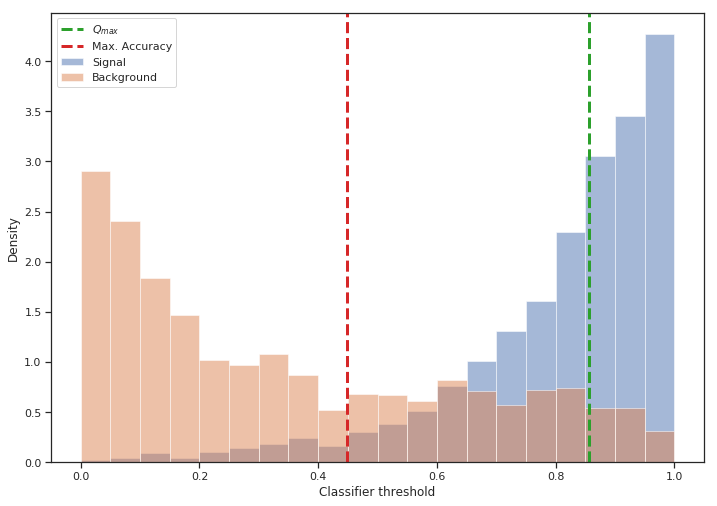

In [28]:
signal = Y_test_predict[Y_test==1]
background = Y_test_predict[Y_test==0]

thr = np.linspace(0,1,50)
tp, fp, acc, Q, Qest = classification_rates(thr,Y_test_predict , Y_test)

QMaxIndex = np.argmax(Q)
accMaxIndex = np.argmax(acc)

print('Maximum Q:', Q[QMaxIndex], ' with accuracy: ', acc[QMaxIndex], ' at threshold: ', thr[QMaxIndex], ' TPR: ', tp[QMaxIndex], ' FPR: ', fp[QMaxIndex])
print('Maximum Accuracy:', acc[accMaxIndex], ' with Q: ', Q[accMaxIndex], ' at threshold: ', thr[accMaxIndex],' TPR: ', tp[accMaxIndex], ' FPR: ', fp[accMaxIndex])



print('Q0.5: ', Qest)


prob_s, n_s, _ = plt.hist(signal, alpha=0.5, range=(0,1), bins=20, density=True, label='Signal')
prob_b, n_b, _ = plt.hist(background, alpha=0.5, range=(0,1), bins=20,density=True, label='Background' );
plt.axvline(thr[QMaxIndex], label="$Q_{max}$", c='#2ca02c',ls='--', lw=3)
plt.axvline(thr[accMaxIndex], label="Max. Accuracy", c='#d62728', ls='--', lw=3)
plt.xlabel('Classifier threshold')
plt.ylabel('Density')
plt.legend()
plt.show()



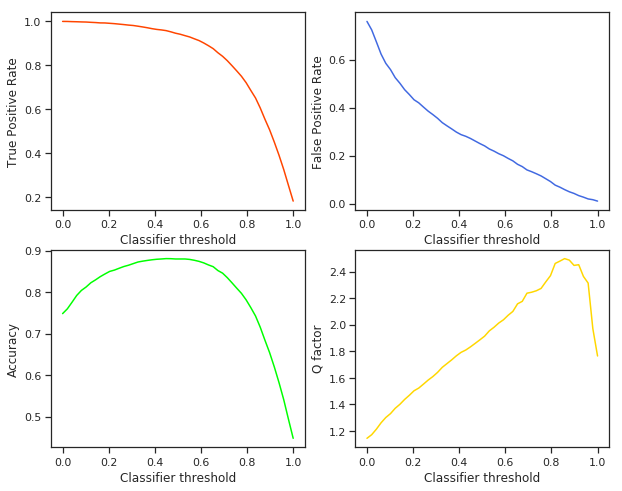

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
axs[0,0].plot(thr, tp, c='orangered')
axs[0,0].set_xlabel('Classifier threshold')
axs[0,0].set_ylabel('True Positive Rate')
axs[0,1].plot(thr, fp, c='royalblue')
axs[0,1].set_xlabel('Classifier threshold')
axs[0,1].set_ylabel('False Positive Rate')
axs[1,0].plot(thr, acc, c='lime')
axs[1,0].set_xlabel('Classifier threshold')
axs[1,0].set_ylabel('Accuracy')
axs[1,1].plot(thr, Q, c='gold')
axs[1,1].set_xlabel('Classifier threshold')
axs[1,1].set_ylabel('Q factor')
plt.show()

### 3.6 Neural Network: Keras+Tensorflow

In [30]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout
from sklearn.model_selection import KFold

def custom_nn_model(layers):
  model = Sequential()
  
  model.add(Dense(layers[0], input_shape=(components_to_keep,), activation='relu'))
  for i in range(1,len(layers)):
      model.add(Dropout(rate=0.1))
      model.add(Dense(layers[i], activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'] )
  return model

Using TensorFlow backend.


In [31]:
layerStack = [
    [50],[100],[50,50],[100,100],[50,50,50],[100,100,100]
]
scores = []
for layers in layerStack:
  current = custom_nn_model(layers)
  cHist = current.fit(X_train, Y_train, epochs=10, validation_split=0.1, verbose=0)
  scores.append(cHist.history['acc'][-1])
  print(layers)
  print(scores[-1])
  print('----------------')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
[50]
0.8625323428861705
----------------
[100]
0.8630331358082972
----------------
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[50, 50]
0.8665386862681591
----------------
[100, 100]
0.8697103747749615
----------------
[50, 50, 50]
0.8675402721074376
----------------
[100, 100, 100]
0.8702946331741594
----------------


In [32]:
bestModel = custom_nn_model(layerStack[np.argmax(scores)])
bestModel.fit(X_train, Y_train, epochs=5)

Epoch 1/5
13313/13313 [==============================] - 2s 151us/step - loss: 0.3991 - acc: 0.8214
Epoch 2/5
13313/13313 [==============================] - 1s 112us/step - loss: 0.3503 - acc: 0.8523
Epoch 3/5
13313/13313 [==============================] - 1s 112us/step - loss: 0.3363 - acc: 0.8589
Epoch 4/5
13313/13313 [==============================] - 1s 110us/step - loss: 0.3323 - acc: 0.8599
Epoch 5/5
13313/13313 [==============================] - 2s 113us/step - loss: 0.3254 - acc: 0.8634


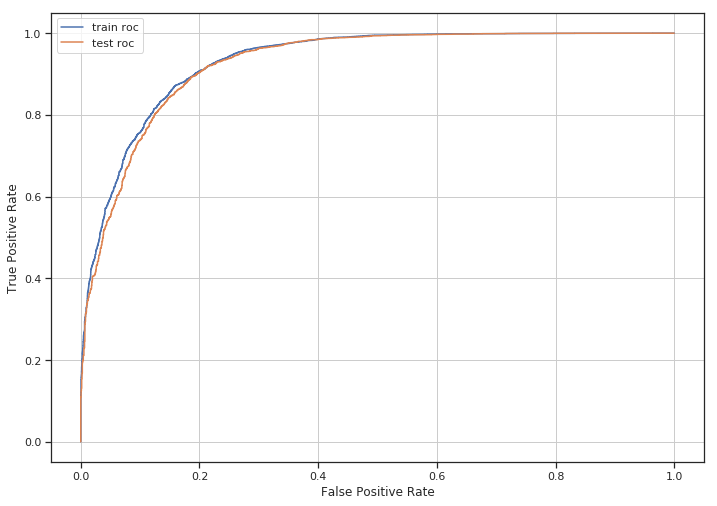

AUC train 0.9314417584792746
AUC test 0.9258875802199588


In [33]:
Y_train_predict = bestModel.predict(X_train)
Y_test_predict = bestModel.predict(X_test)
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, Y_train_predict, pos_label =1)
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, Y_test_predict, pos_label =1)
plt.figure()
plt.plot(train_fpr, train_tpr, label='train roc')
plt.plot(test_fpr, test_tpr, label='test roc')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()
print('AUC train', roc_auc_score(Y_train, Y_train_predict))
print('AUC test', roc_auc_score(Y_test, Y_test_predict))

Maximum Q: 3.3146907627499123  with accuracy:  0.5252365930599369  at threshold:  0.9591836734693877  TPR:  0.2962382445141066  FPR:  0.007987220447284345
Maximum Accuracy: 0.8781983876621101  with Q:  1.8172867071642986  at threshold:  0.4897959183673469  TPR:  0.9535005224660397  FPR:  0.27529286474973375
Q0.5:  2.5465952104523235


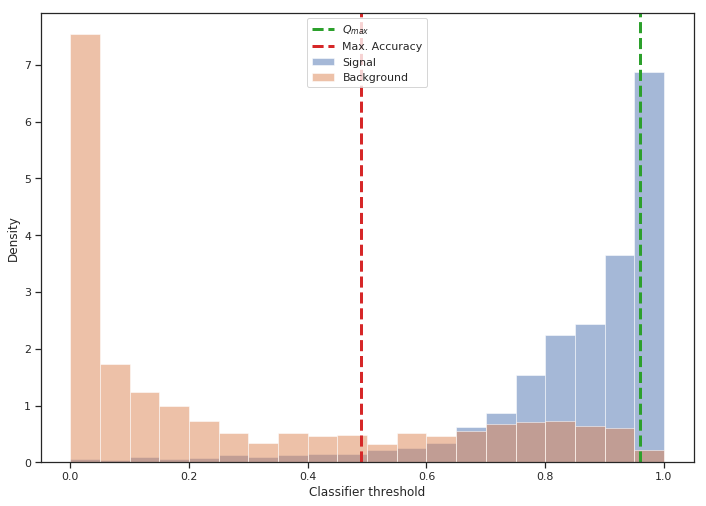

In [34]:
signal = Y_test_predict[Y_test==1]
background = Y_test_predict[Y_test==0]

thr = np.linspace(0,1,50)
tp, fp, acc, Q, Qest= classification_rates(thr,Y_test_predict.ravel() , Y_test)

QMaxIndex = np.argmax(Q)
accMaxIndex = np.argmax(acc)

print('Maximum Q:', Q[QMaxIndex], ' with accuracy: ', acc[QMaxIndex], ' at threshold: ', thr[QMaxIndex], ' TPR: ', tp[QMaxIndex], ' FPR: ', fp[QMaxIndex])
print('Maximum Accuracy:', acc[accMaxIndex], ' with Q: ', Q[accMaxIndex], ' at threshold: ', thr[accMaxIndex],' TPR: ', tp[accMaxIndex], ' FPR: ', fp[accMaxIndex])



print('Q0.5: ', Qest)


plt.hist(signal, alpha=0.5, range=(0,1), bins=20, density=True, label='Signal')
plt.hist(background, alpha=0.5, range=(0,1), bins=20, density=True, label='Background');
plt.axvline(thr[QMaxIndex], label="$Q_{max}$", c='#2ca02c',ls='--', lw=3)
plt.axvline(thr[accMaxIndex], label="Max. Accuracy", c='#d62728', ls='--', lw=3)
plt.xlabel('Classifier threshold')
plt.ylabel('Density')
plt.legend(loc=9)
plt.show()

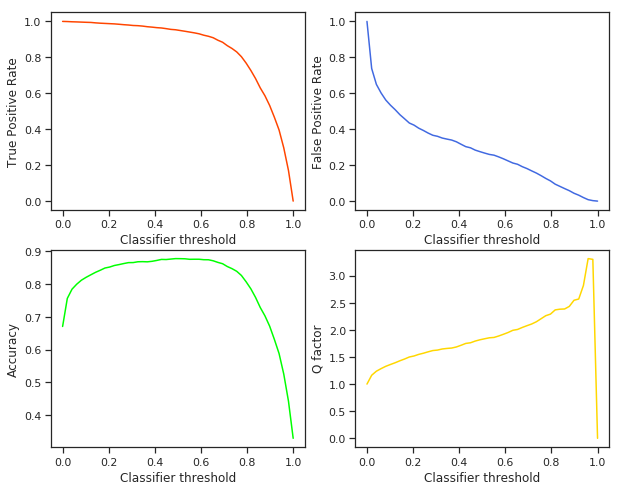

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
axs[0,0].plot(thr, tp, c='orangered')
axs[0,0].set_xlabel('Classifier threshold')
axs[0,0].set_ylabel('True Positive Rate')
axs[0,1].plot(thr, fp, c='royalblue')
axs[0,1].set_xlabel('Classifier threshold')
axs[0,1].set_ylabel('False Positive Rate')
axs[1,0].plot(thr, acc, c='lime')
axs[1,0].set_xlabel('Classifier threshold')
axs[1,0].set_ylabel('Accuracy')
axs[1,1].plot(thr, Q, c='gold')
axs[1,1].set_xlabel('Classifier threshold')
axs[1,1].set_ylabel('Q factor')
plt.show()

## 4. Results and conclusion

| Model  | Q0.5 |Qmax|$FPR_{Q_{max}}$| Max Acc|$FPR_{Acc_{max}}$|AUC Train|AUC Test
|------|------|------|------|------|------|------|------|
|Logistic|1.54|1.62|0.15|0.80|0.39|0.84|0.84
|Random Forest|2.70|3.07|0.01|0.88|0.20|0.99|0.93
|XGBoost|2.80|2.80|0.04|0.89|0.24|0.97|0.93
|NN - sklearn|2.45|2.46|0.06|0.88|0.27|0.95|0.92
|NN - keras|2.55|3.31|0.01|0.88|0.27|0.93|0.93

Generally speaking, Logistic Regression is a low-complexity model with a straight probabilistic interpretation, yet it provides the lowest scores within all criteria. In fact, in most of the cases out-of.the-box ML algorithms  learn by maximizing the accuracy, neglecting the FPR. We also followed this approach to tune the hypermarameters and choose the optimal models. Anyway, one could try to implement a learning procedure based on a custom performance indicator, such as the $Q$ factor. 

RF and NN score above $90\%$ on both the Trainig and Test set. Besides, their $Q$ factors are similar among them and higher than the Logistic Regression. 
In conclusion, we opt for the XGBoost model: it has the highest $Q_{0.5}$, _Accuracy_ and _AUC_. Compared with Keras, at $Q_{max}$ XGBoost also has a double $TPR$ ($0.54$ vs. $0.24$) with $FPR=0.04$, even tough Keras scores the lowest $FPR=0.01$.

Nevertheless, new data analysis techniques suggest that Machine Learning can be exploited to gain a fresh insight on physics with just raw data from experiments (e.g. convolutiona neural networks are being used for classification directly from raw camera images).

In the end we can say that we got results comparable to the ones in _Bock, R.K. et al. (2004). 
Methods for multidimensional event classification: a case study using images from a Cherenkov gamma-ray telescope. 
Nucl.Instr.Meth. A, 516, pp. 511-528._